In [11]:
import sys, time, timeit, cProfile, pstats, importlib, os, math, scipy
sys.path.insert(0,'/home/uq/apps/muq2inst/lib')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 7.)
matplotlib.rcParams.update({'font.size': 22})

import numpy as np
import itertools as it
from numpy.polynomial.legendre import legvander

from Database import *
from Densities import *
from MultiIndex import *
from Surrogates import *
from Transport import *

import plotutil, randutil

In [88]:
[2**(-2*np.log2(i+1)) for i in range(1,201)]

[0.25,
 0.11111111111111113,
 0.0625,
 0.04000000000000001,
 0.027777777777777783,
 0.02040816326530612,
 0.015625,
 0.012345679012345682,
 0.010000000000000002,
 0.008264462809917354,
 0.006944444444444446,
 0.005917159763313609,
 0.00510204081632653,
 0.004444444444444444,
 0.00390625,
 0.003460207612456749,
 0.0030864197530864204,
 0.0027700831024930757,
 0.002499999999999999,
 0.0022675736961451235,
 0.0020661157024793385,
 0.0018903591682419656,
 0.0017361111111111114,
 0.0016000000000000007,
 0.0014792899408284032,
 0.0013717421124828538,
 0.0012755102040816334,
 0.001189060642092747,
 0.001111111111111111,
 0.0010405827263267435,
 0.0009765625,
 0.0009182736455463729,
 0.0008650519031141872,
 0.000816326530612245,
 0.0007716049382716051,
 0.0007304601899196491,
 0.0006925207756232689,
 0.0006574621959237341,
 0.0006249999999999998,
 0.0005948839976204639,
 0.0005668934240362809,
 0.0005408328826392645,
 0.0005165289256198346,
 0.0004938271604938271,
 0.0004725897920604914,
 0.00

# Profiling Surrogate Construction

In [86]:
t = Rosenbrock(a=.15, b=10)
m = TotalDegreeSet(dim=2, order=9)

points, weights = get_sample_points_and_weights('wls', m)
rhs = np.squeeze(t.evalSqrt(points))
lhs = legendreutil.evaluate_basis(points, m)
print(m.cardinality, points.shape, rhs.shape, lhs.shape)

if weights is not None:
    for i in range(lhs.shape[0]) :
        lhs[i,:] *= weights[i]
        rhs[i] *= weights[i]

def run_nplstsq() :
    coeffs, res, rank, s = np.linalg.lstsq(lhs, rhs, rcond=None)
    #print(res/rhs.shape[0], rank)
    #print(s)
    return coeffs

def run_nppinv() :
    inv = np.linalg.pinv(lhs)
    return np.dot(inv, rhs)

def run_splstsq() :
    coeffs, _, _, _ = scipy.linalg.lstsq(lhs, rhs)
    return coeffs

def run_optimize() :
    def func(x) :
        return np.dot(lhs, x.T) - rhs
    coeffs, _ = scipy.optimize.leastsq(func, np.zeros((lhs.shape[1],)))
    return coeffs

x = run_nplstsq()

55 (2, 2200) (2200,) (2200, 55)
[0.00862235] 55
[23.40830114 23.14720178 22.84668282 22.34100962 21.85139675 21.33151785
 20.96468981 20.50644781 20.053087   19.95806551 19.63828657 19.09709324
 18.85933355 18.59433476 18.10617269 17.9428856  17.31888695 17.07112903
 16.86836911 16.37230611 16.04601958 15.77097308 15.3171758  15.16737062
 14.8383832  14.51947229 14.42277025 14.0367189  13.93246398 13.54502661
 13.43232531 13.30724461 12.98024161 12.05005489 11.91110769 11.70581374
 11.50651549 10.99284557 10.94263373 10.70936685 10.49717672 10.29976824
  9.87153589  9.76370775  9.47880244  9.20349956  8.91769722  8.84735949
  8.70015154  8.14197036  7.94346712  7.27938749  6.70109161  6.46457062
  5.88981337]


In [78]:
c1 = run_nplstsq()
c2 = run_optimize()
print(c1 - c2)

[ 1.73752124e-11  3.17801341e-12 -3.60003694e-13 -9.99828415e-11
 -3.35051570e-11  1.35865486e-11 -4.69166477e-11  7.88503464e-12
 -3.72222808e-11  1.17669263e-10  2.66446379e-11  1.58889450e-10
  2.06712733e-11  2.97639660e-11  1.15699277e-10 -2.82425056e-11
  7.25799759e-11 -6.74612745e-11  4.60941250e-11  3.03548853e-11
  3.39333023e-11  7.59792507e-11 -7.14941162e-11 -3.30795599e-11
  7.92106103e-11  1.43247220e-11 -2.49446991e-11 -5.29600877e-11
  1.69469100e-10  5.91149039e-11 -4.07486176e-12  1.47909579e-10
 -1.29371467e-10  4.53608366e-11  7.36458117e-11  1.24160265e-11
  6.35609620e-11 -3.44923985e-11  3.41061901e-11  1.22174389e-10
  1.48716438e-11  1.44916660e-10  4.50390038e-11 -2.22087227e-11
  1.16249513e-10  2.26422700e-12  3.89271254e-11  9.93212387e-11
 -8.13542705e-11 -4.16625935e-13  5.56199208e-11  6.48072828e-11
  4.54366861e-11  2.20748940e-11  2.58438913e-11]


In [47]:
timeit.repeat(run_nplstsq, repeat=1, number=1)

[73.21716557500076]

In [80]:
timeit.repeat(run_optimize, repeat=1, number=1)

[238.19883692000076]

In [48]:
timeit.repeat(run_splstsq, repeat=1, number=1)

[73.77029162899998,
 78.31270684000083,
 85.31312828299997,
 78.64938330199948,
 84.29982718700012]

In [24]:
cProfile.run('run_nplstsq()', 'stats_run_nplstsq')

In [32]:
cProfile.run('run_nppinv()', 'stats_run_nppinv')

In [33]:
cProfile.run('run_splstsq()', 'stats_run_splstsq')

In [36]:
p = pstats.Stats('stats_run_splstsq')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats()

Fri Apr  1 12:33:20 2022    stats_run_splstsq

         52 function calls in 6.928 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.928    6.928 {built-in method builtins.exec}
        1    0.000    0.000    6.928    6.928 <string>:1(<module>)
        1    0.000    0.000    6.928    6.928 /tmp/ipykernel_5801/2816693092.py:22(run_splstsq)
        1    6.914    6.914    6.928    6.928 /usr/lib/python3.10/site-packages/scipy/linalg/_basic.py:1036(lstsq)
        2    0.000    0.000    0.013    0.007 /usr/lib/python3.10/site-packages/scipy/_lib/_util.py:241(_asarray_validated)
        2    0.012    0.006    0.013    0.007 /usr/lib/python3.10/site-packages/numpy/lib/function_base.py:537(asarray_chkfinite)
        3    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.001    0.001 {method 'all' of 'numpy.ndarray' objects}
        2    0.00

# Profiling Transport Map Evaluation

In [3]:
t = Rosenbrock(a=.15, b=10)
m = TotalDegreeSet(dim=2, order=9)
s = Legendre(multis=m, target=t, method='wls')
r = TransportMap(s)

def run() :
    p = randutil.points(2,1000)
    i = np.zeros(p.shape)
    for j in range(p.shape[1]) :
        i[:,j] = r.inveval(p[:,j])

In [33]:
cProfile.run('run()', 'stats')

In [2]:
p = pstats.Stats('stats')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats()

Tue Mar 15 10:59:18 2022    stats

         28670007 function calls in 52.949 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   52.949   52.949 {built-in method builtins.exec}
        1    0.000    0.000   52.949   52.949 <string>:1(<module>)
        1    0.003    0.003   52.949   52.949 /tmp/ipykernel_5284/3898437028.py:6(run)
     1000    0.136    0.000   52.945    0.053 /home/uq/spatram_tmp/Transport.py:47(inveval)
    61000    5.387    0.000   52.776    0.001 /home/uq/spatram_tmp/Transport.py:14(eval)
   122000   22.590    0.000   33.887    0.000 /home/uq/spatram_tmp/legendreutil.py:22(get_integrated_products)
  2745000    3.658    0.000   12.718    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   122000    7.742    0.000    9.581    0.000 /usr/lib/python3.10/site-packages/numpy/polynomial/legendre.py:1126(legvander)
   671000    0.364    0.000    8.415    0.

# Evaluating the Legendre basis

In [3]:
def setup(d=2, n=10, k=7) :

    rng = np.random.default_rng()
    x = rng.uniform(low=-1, high=1, size=(d, n))
    van = legvander(x, k)
    indices = [idx for idx in it.product(range(k+1), repeat=d)]
    m = len(indices)
    mat = np.zeros((n, m))
    return x, van, indices, mat

def run1(x, van, indices, mat, d=2, n=10, k=7) :
    for i in range(n) :
        for j in range((k+1)**d) :
            mat[i,j] = np.prod([van[k,i,indices[j][k if k < len(indices[j]) else 0]] for k in range(d)])
            mat[i,j] *= np.prod([np.sqrt((2*i + 1)/2) for i in indices[j]])
    return mat
            
def run2(x, van, indices, mat, d=2, n=10, k=7) :
    for i in range(n) :
        mat[i,:] = [np.prod([van[k,i,idx[di if di < len(idx) else 0]] for di in range(d)])*np.prod([np.sqrt((2*l + 1)/2) for l in idx]) for idx in it.product(range(k+1), repeat=d)]
    return mat
            
def run3(x, van, indices, mat, d=2, n=10, k=7) :
    map1 = lambda l : np.sqrt((2*l + 1)/2)
    map2 = lambda q : van[q[0],i,q[1]]
    for i in range(n) :
        mat[i,:] = [math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in it.product(range(k+1), repeat=d)]
    return mat
        
def run4(x, van, indices, mat, d=2, n=10, k=7) :
    map1 = lambda l : np.sqrt((2*l + 1)/2)
    map2 = lambda q : van[q[0],:,q[1]]
    return np.array([math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in indices]).T


def run5(x, van, indices, mat, d=2, n=10, k=7) :
    def map1(l) : return np.sqrt((2*l + 1)/2)
    def map2(q) : return van[q[0],:,q[1]]
    return np.array([math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in indices]).T

def run6(x, van, indices, mat, d=2, n=10, k=7) :
    def map1(l) : return np.sqrt((2*l + 1)/2)
    def map2(q) : return van[q[0],:,q[1]]
    return np.array([math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in indices]).T
    
d = 2
k = 2
n = 3
x, van, indices, mat = setup(d=d, n=n, k=k)
print(run1(x, van, indices, np.zeros((n, (k+1)**d)), d=d, n=n, k=k).T)
print(run5(x, van, indices, np.zeros((n, (k+1)**d)), d=d, n=n, k=k).T)

[[ 0.5         0.5         0.5       ]
 [-0.0818832   0.52708955  0.61128947]
 [-0.54402447  0.062215    0.27654529]
 [-0.56133557 -0.68074749  0.84297877]
 [ 0.09192791 -0.71762978  1.03060808]
 [ 0.61076058 -0.0847054   0.46624361]
 [ 0.14556271  0.47721526  1.02996243]
 [-0.02383828  0.50307035  1.25921037]
 [-0.15837935  0.05937989  0.56966251]]
[[ 0.5         0.5         0.5       ]
 [-0.0818832   0.52708955  0.61128947]
 [-0.54402447  0.062215    0.27654529]
 [-0.56133557 -0.68074749  0.84297877]
 [ 0.09192791 -0.71762978  1.03060808]
 [ 0.61076058 -0.0847054   0.46624361]
 [ 0.14556271  0.47721526  1.02996243]
 [-0.02383828  0.50307035  1.25921037]
 [-0.15837935  0.05937989  0.56966251]]


In [26]:
dslong = [2,3,4,5,6,7,8]
ds = [2,3,4,5]

In [6]:
times1 = [timeit.repeat(setup = 'from __main__ import setup, run1; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run1(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

In [8]:
times3 = [timeit.repeat(setup = 'from __main__ import setup, run3; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run3(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

In [9]:
times4 = [timeit.repeat(setup = 'from __main__ import setup, run4; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run4(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

In [30]:
times6 = [timeit.repeat(setup = 'from __main__ import setup, run6; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run6(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

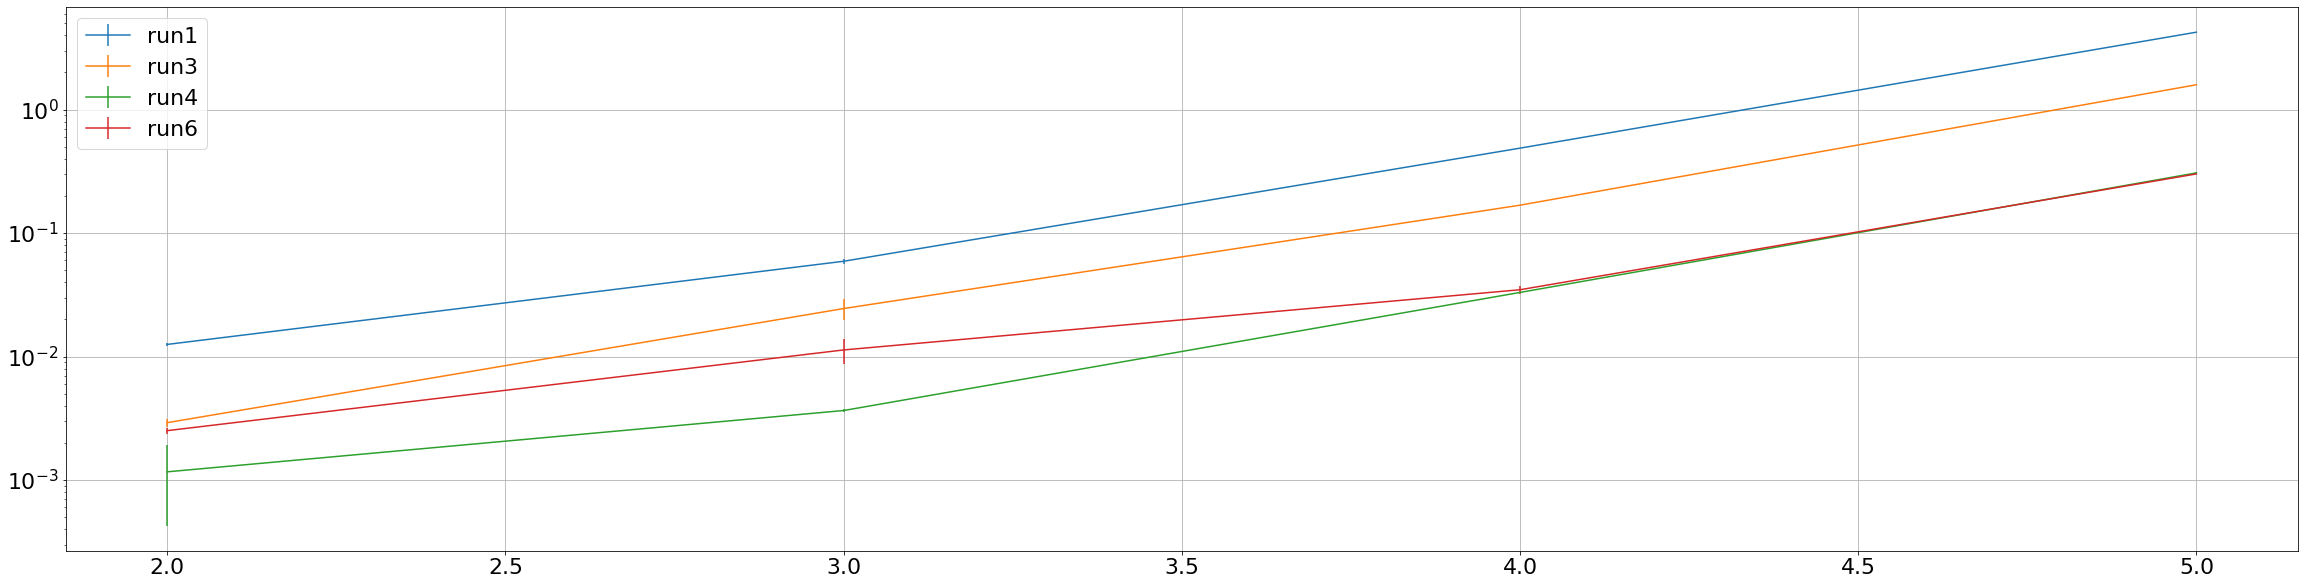

In [31]:
fig = plt.figure(figsize=(40,10))
ax = plotutil.get_ax(fig, 1, 1, xlabel='', logaxis=['y'])
ax.errorbar(ds, np.mean(times1, axis=1), np.std(times1, axis=1), label='run1')
ax.errorbar(ds, np.mean(times3, axis=1), np.std(times3, axis=1), label='run3')
ax.errorbar(ds, np.mean(times4, axis=1), np.std(times4, axis=1), label='run4')
ax.errorbar(ds, np.mean(times6, axis=1), np.std(times6, axis=1), label='run6')
ax.legend()
plt.show()